
Cluster Analysis Menu:
1. K-Means Clustering
2. Agglomerative Clustering
3. DBSCAN Clustering
4. Show Execution Time
5. Exit
Enter your choice (1-5): 1
K-Means Silhouette Score: 0.43


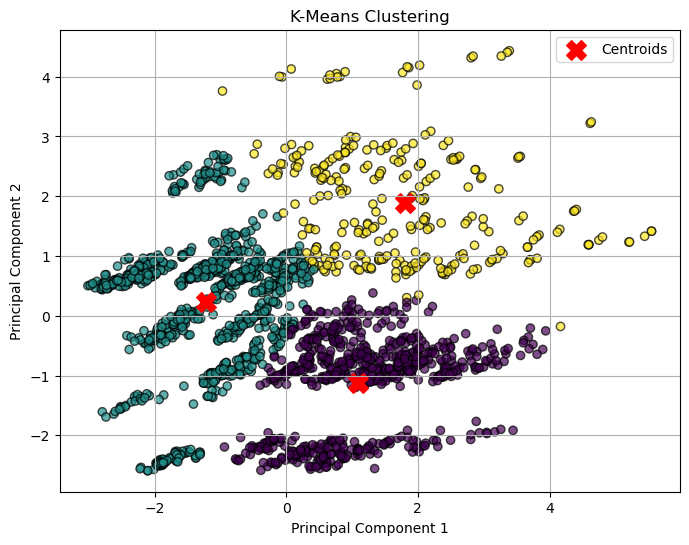


Cluster Analysis Menu:
1. K-Means Clustering
2. Agglomerative Clustering
3. DBSCAN Clustering
4. Show Execution Time
5. Exit
Enter your choice (1-5): 2
Agglomerative Clustering Silhouette Score: 0.40


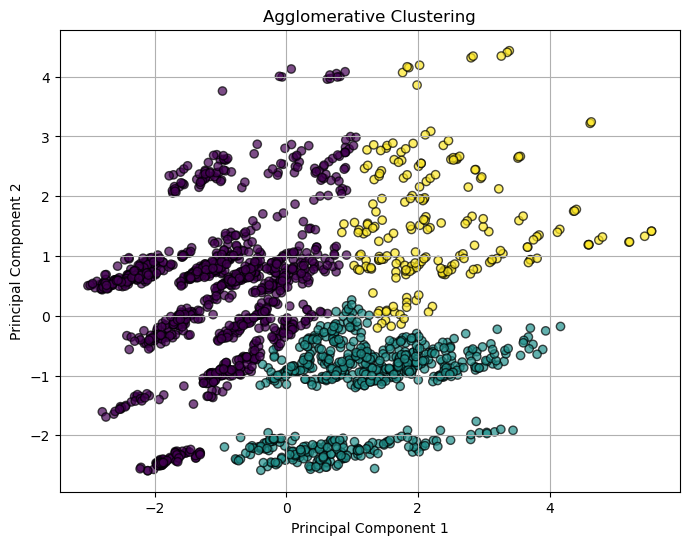

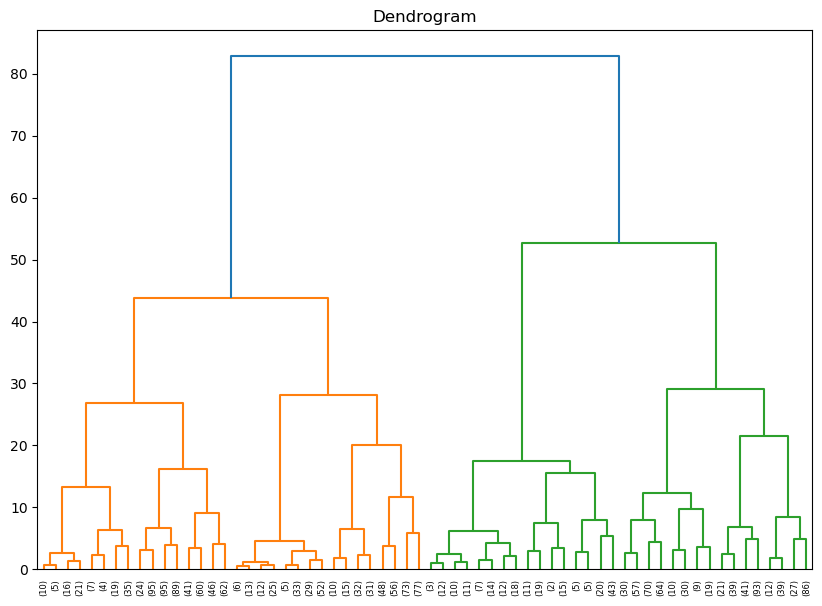


Cluster Analysis Menu:
1. K-Means Clustering
2. Agglomerative Clustering
3. DBSCAN Clustering
4. Show Execution Time
5. Exit
Enter your choice (1-5): 3
DBSCAN found 1 clusters


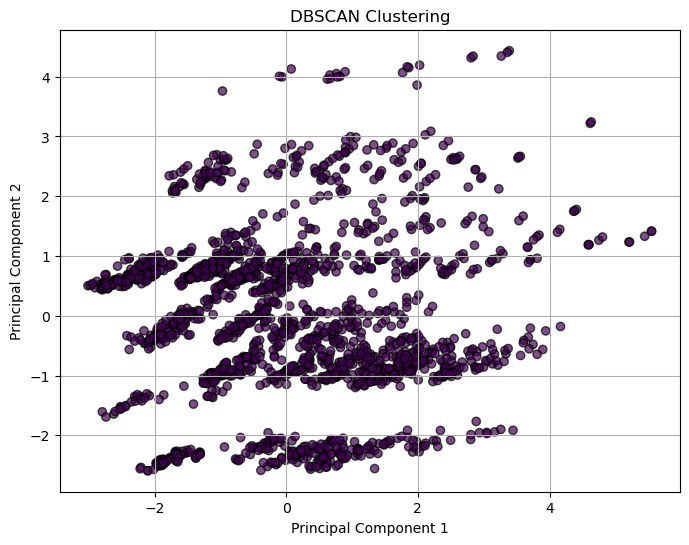


Cluster Analysis Menu:
1. K-Means Clustering
2. Agglomerative Clustering
3. DBSCAN Clustering
4. Show Execution Time
5. Exit
Enter your choice (1-5): 4

PySpark Execution Time: 7.26 seconds
Pandas Execution Time: 0.00 seconds

Cluster Analysis Menu:
1. K-Means Clustering
2. Agglomerative Clustering
3. DBSCAN Clustering
4. Show Execution Time
5. Exit
Enter your choice (1-5): 5
Exiting program. Goodbye!


In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Start Spark Session
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

# Load dataset and start time tracking for PySpark execution
start_time_spark = time.time()
file_path = "segmentation data.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop rows with nulls (if any)
data = data.dropna()

# Select features (excluding ID)
feature_cols = ["Sex", "Marital status", "Age", "Education", "Income", "Occupation", "Settlement size"]
features = data.select(*feature_cols)

# Convert to feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
feature_vector = assembler.transform(features).select("features")

# Apply Standard Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(feature_vector)
scaled_features = scaler_model.transform(feature_vector)

# Perform PCA for dimensionality reduction
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_features)
pca_result = pca_model.transform(scaled_features).select("pca_features")

# Convert PySpark DataFrame to Pandas for visualization
pca_pd = pca_result.limit(5000).toPandas()
pca_pd[["PC1", "PC2"]] = pd.DataFrame(pca_pd["pca_features"].apply(lambda x: x.toArray()).tolist())

# Sample data for clustering
sampled_features = pca_pd[['PC1', 'PC2']].values

# End time tracking for PySpark execution
end_time_spark = time.time()
spark_execution_time = end_time_spark - start_time_spark

# Start time tracking for Pandas execution
start_time_pandas = time.time()

# --- Clustering Functions ---

def kmeans_clustering():
    from sklearn.cluster import MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=3, batch_size=1000, random_state=42)
    clusters = kmeans.fit_predict(sampled_features)
    silhouette_avg = silhouette_score(sampled_features, clusters)
    print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(sampled_features[:, 0], sampled_features[:, 1], c=clusters, cmap='viridis', alpha=0.7, edgecolor='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title('K-Means Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid()
    plt.show()

def agglomerative_clustering():
    agg_clustering = AgglomerativeClustering(n_clusters=3)
    clusters = agg_clustering.fit_predict(sampled_features)
    silhouette_avg = silhouette_score(sampled_features, clusters)
    print(f"Agglomerative Clustering Silhouette Score: {silhouette_avg:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(sampled_features[:, 0], sampled_features[:, 1], c=clusters, cmap='viridis', alpha=0.7, edgecolor='k')
    plt.title('Agglomerative Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()

    linked = linkage(sampled_features, method='ward')
    plt.figure(figsize=(10, 7))
    dendrogram(linked, truncate_mode='level', p=5)
    plt.title('Dendrogram')
    plt.show()

def dbscan_clustering():
    dbscan = DBSCAN(eps=1.5, min_samples=5, n_jobs=-1)
    clusters = dbscan.fit_predict(sampled_features)
    unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"DBSCAN found {unique_clusters} clusters")

    plt.figure(figsize=(8, 6))
    plt.scatter(sampled_features[:, 0], sampled_features[:, 1], c=clusters, cmap='viridis', alpha=0.7, edgecolor='k')
    plt.title('DBSCAN Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()

# --- End time tracking for Pandas ---
end_time_pandas = time.time()
pandas_execution_time = end_time_pandas - start_time_pandas

# --- Menu ---
while True:
    print("\nCluster Analysis Menu:")
    print("1. K-Means Clustering")
    print("2. Agglomerative Clustering")
    print("3. DBSCAN Clustering")
    print("4. Show Execution Time")
    print("5. Exit")

    choice = input("Enter your choice (1-5): ")

    if choice == '1':
        kmeans_clustering()
    elif choice == '2':
        agglomerative_clustering()
    elif choice == '3':
        dbscan_clustering()
    elif choice == '4':
        print(f"\nPySpark Execution Time: {spark_execution_time:.2f} seconds")
        print(f"Pandas Execution Time: {pandas_execution_time:.2f} seconds")
    elif choice == '5':
        print("Exiting program. Goodbye!")
        break
    else:
        print("Invalid choice. Please try again.")

# Stop Spark Session
spark.stop()
